# Training FSRS on simulated data

Requirement: fsrs-optimizer >= 5.4.1

In [1]:
import numpy as np
import pandas as pd

from fsrs_optimizer import simulate, Optimizer

initial_parameters = [
    1.1596,
    1.7974,
    13.1205,
    49.3729,
    7.2303,
    0.5081,
    1.5371,
    0.0010,
    1.5052,
    0.1261,
    0.9735,
    1.8924,
    0.1486,
    0.2407,
    2.1937,
    0.1518,
    3.0699,
    0.4636,
    0.6048,
]


def generate_revlog_from_simulation(initial_parameters, learn_span):
    _, _, _, _, _, revlogs = simulate(
        w=initial_parameters,
        learn_span=learn_span,
        first_rating_offset=np.array([0, 0, 0, 0]),
        first_session_len=np.array([0, 0, 0, 0]),
        forget_rating_offset=0,
        forget_session_len=0,
        fuzz=True,
    )

    flattened_revlogs = []

    for day in revlogs:
        card_ids = revlogs[day]["card_id"]
        ratings = revlogs[day]["rating"]
        for card_id, rating in zip(card_ids, ratings):
            flattened_revlogs.append(
                {"card_id": card_id, "review_rating": int(rating), "day": day}
            )
    return flattened_revlogs

In [2]:
from itertools import accumulate


def preprocess_revlog(flattened_revlogs):
    df = pd.DataFrame(flattened_revlogs)
    df["review_time"] = range(1, df.shape[0] + 1)
    df.sort_values(by=["card_id", "day"], inplace=True, ignore_index=True)
    df["delta_t"] = df.groupby("card_id")["day"].diff().fillna(0).astype(int)
    df["i"] = df.groupby("card_id").cumcount() + 1
    df.loc[df["i"] == 1, "delta_t"] = -1

    def cum_concat(x):
        return list(accumulate(x))

    t_history_list = df.groupby("card_id", group_keys=False)["delta_t"].apply(
        lambda x: cum_concat([[max(0, int(i))] for i in x])
    )
    df["t_history"] = [
        ",".join(map(str, item[:-1])) for sublist in t_history_list for item in sublist
    ]
    r_history_list = df.groupby("card_id", group_keys=False)["review_rating"].apply(
        lambda x: cum_concat([[i] for i in x])
    )
    df["r_history"] = [
        ",".join(map(str, item[:-1])) for sublist in r_history_list for item in sublist
    ]
    last_rating = []
    for t_sublist, r_sublist in zip(t_history_list, r_history_list):
        for t_history, r_history in zip(t_sublist, r_sublist):
            flag = True
            for t, r in zip(reversed(t_history[:-1]), reversed(r_history[:-1])):
                if t > 0:
                    last_rating.append(r)
                    flag = False
                    break
            if flag:
                last_rating.append(r_history[0])
    df["last_rating"] = last_rating
    df = df[
        (df["review_rating"] != 0)
        & (df["r_history"].str.contains("0") == 0)
        & (df["delta_t"] != 0)
    ].copy()

    df["i"] = df.groupby("card_id").cumcount() + 1
    df["first_rating"] = df["r_history"].map(lambda x: x[0] if len(x) > 0 else "")
    df["y"] = df["review_rating"].map(lambda x: {1: 0, 2: 1, 3: 1, 4: 1}[x])
    df = df[(df["i"] > 1) & (df["delta_t"] > 0)].copy()
    return df

In [3]:
import matplotlib.pyplot as plt


def train_and_evaluate(df):
    plt.close("all")
    sample_size = len(df)
    print(f"sample size: {sample_size}")
    optimizer = Optimizer()
    optimizer.S0_dataset_group = (
        df[df["i"] == 2]
        .groupby(by=["first_rating", "delta_t"], group_keys=False)
        .agg({"y": ["mean", "count"]})
        .reset_index()
    )
    optimizer.define_model()
    optimizer.pretrain(dataset=df, verbose=False)
    optimizer.train(verbose=False)
    loss_before, loss_after = optimizer.evaluate(save_to_file=False)
    print(f"loss before: {loss_before:.4f}, loss after: {loss_after:.4f}")
    metrics, figures = optimizer.calibration_graph(verbose=False)
    rmse = metrics["all"]["RMSE(bins)"]
    auc = metrics["all"]["AUC"]
    print(f"RMSE(bins): {rmse:.4f}")
    print(f"AUC: {auc:.4f}")
    deviations = []
    for param, trained_param in zip(initial_parameters, optimizer.w):
        smape = abs(param - trained_param) / ((abs(param) + abs(trained_param)) / 2)
        deviations.append(smape)
        print(f"{param} -> {trained_param}: SMAPE={smape:.4%}")
    avg_smape = np.mean(deviations)
    print(f"Avg. SMAPE: {avg_smape:.4%}")
    return sample_size, loss_after, rmse, auc, avg_smape, optimizer.dataset

def evaluate_initial_parameters(dataset):
    optimizer = Optimizer()
    optimizer.dataset = dataset
    optimizer.w = initial_parameters
    loss_before, loss_after = optimizer.evaluate(save_to_file=False)
    print(f"loss before: {loss_before:.4f}, loss after: {loss_after:.4f}")
    metrics, figures = optimizer.calibration_graph(verbose=False)
    rmse = metrics["all"]["RMSE(bins)"]
    auc = metrics["all"]["AUC"]
    print(f"RMSE(bins): {rmse:.4f}")
    print(f"AUC: {auc:.4f}")
    return loss_after, rmse, auc

learn_span: 7


sample size: 272


  0%|          | 0/272 [00:00<?, ?it/s]

loss before: 0.2788, loss after: 0.2343
RMSE(bins): 0.0504
AUC: 0.7766
1.1596 -> 1.2245: SMAPE=5.4444%
1.7974 -> 6.3846: SMAPE=112.1291%
13.1205 -> 20.9057: SMAPE=45.7600%
49.3729 -> 58.286: SMAPE=16.5580%
7.2303 -> 7.1068: SMAPE=1.7228%
0.5081 -> 0.5472: SMAPE=7.4102%
1.5371 -> 1.4857: SMAPE=3.4008%
0.001 -> 0.001: SMAPE=0.0000%
1.5052 -> 1.6583: SMAPE=9.6792%
0.1261 -> 0.1046: SMAPE=18.6389%
0.9735 -> 1.1232: SMAPE=14.2796%
1.8924 -> 1.873: SMAPE=1.0304%
0.1486 -> 0.1202: SMAPE=21.1310%
0.2407 -> 0.1899: SMAPE=23.5950%
2.1937 -> 2.2704: SMAPE=3.4363%
0.1518 -> 0.3187: SMAPE=70.9458%
3.0699 -> 3.018: SMAPE=1.7050%
0.4636 -> 0.5166: SMAPE=10.8141%
0.6048 -> 0.6621: SMAPE=9.0457%
Avg. SMAPE: 19.8277%
loss before: 0.2788, loss after: 0.2462
RMSE(bins): 0.0606
AUC: 0.7171
--------------------------------
learn_span: 15


sample size: 870


  0%|          | 0/870 [00:00<?, ?it/s]

loss before: 0.3301, loss after: 0.3088
RMSE(bins): 0.0462
AUC: 0.6190
1.1596 -> 1.2456: SMAPE=7.1512%
1.7974 -> 1.6525: SMAPE=8.4002%
13.1205 -> 10.0092: SMAPE=26.9031%
49.3729 -> 49.4384: SMAPE=0.1326%
7.2303 -> 7.1822: SMAPE=0.6675%
0.5081 -> 0.4894: SMAPE=3.7494%
1.5371 -> 1.4486: SMAPE=5.9283%
0.001 -> 0.0163: SMAPE=176.8786%
1.5052 -> 1.5249: SMAPE=1.3003%
0.1261 -> 0.1316: SMAPE=4.2685%
0.9735 -> 1.0121: SMAPE=3.8880%
1.8924 -> 1.8927: SMAPE=0.0159%
0.1486 -> 0.1013: SMAPE=37.8551%
0.2407 -> 0.1988: SMAPE=19.0671%
2.1937 -> 2.2646: SMAPE=3.1806%
0.1518 -> 0.2279: SMAPE=40.0843%
3.0699 -> 3.0502: SMAPE=0.6438%
0.4636 -> 0.5166: SMAPE=10.8141%
0.6048 -> 0.6621: SMAPE=9.0457%
Avg. SMAPE: 18.9460%
loss before: 0.3301, loss after: 0.3105
RMSE(bins): 0.0476
AUC: 0.6000
--------------------------------
learn_span: 30


sample size: 2223


  0%|          | 0/2223 [00:00<?, ?it/s]

loss before: 0.3609, loss after: 0.3364
RMSE(bins): 0.0298
AUC: 0.5978
1.1596 -> 1.2261: SMAPE=5.5749%
1.7974 -> 2.5866: SMAPE=36.0036%
13.1205 -> 9.1998: SMAPE=35.1312%
49.3729 -> 26.042: SMAPE=61.8734%
7.2303 -> 7.2577: SMAPE=0.3782%
0.5081 -> 0.5709: SMAPE=11.6404%
1.5371 -> 1.4059: SMAPE=8.9161%
0.001 -> 0.0492: SMAPE=192.0319%
1.5052 -> 1.4723: SMAPE=2.2099%
0.1261 -> 0.1638: SMAPE=26.0090%
0.9735 -> 0.9555: SMAPE=1.8663%
1.8924 -> 1.8902: SMAPE=0.1163%
0.1486 -> 0.1147: SMAPE=25.7501%
0.2407 -> 0.2233: SMAPE=7.5000%
2.1937 -> 2.2043: SMAPE=0.4820%
0.1518 -> 0.135: SMAPE=11.7155%
3.0699 -> 2.8501: SMAPE=7.4257%
0.4636 -> 0.5421: SMAPE=15.6110%
0.6048 -> 0.7201: SMAPE=17.4051%
Avg. SMAPE: 24.6127%
loss before: 0.3609, loss after: 0.3383
RMSE(bins): 0.0324
AUC: 0.5741
--------------------------------
learn_span: 60


sample size: 5325


  0%|          | 0/5325 [00:00<?, ?it/s]

loss before: 0.3586, loss after: 0.3330
RMSE(bins): 0.0235
AUC: 0.5677
1.1596 -> 1.0484: SMAPE=10.0725%
1.7974 -> 1.7863: SMAPE=0.6195%
13.1205 -> 12.6959: SMAPE=3.2894%
49.3729 -> 36.0584: SMAPE=31.1701%
7.2303 -> 7.1999: SMAPE=0.4213%
0.5081 -> 0.5787: SMAPE=12.9923%
1.5371 -> 1.4761: SMAPE=4.0489%
0.001 -> 0.0016: SMAPE=46.1538%
1.5052 -> 1.538: SMAPE=2.1556%
0.1261 -> 0.3179: SMAPE=86.3964%
0.9735 -> 1.0352: SMAPE=6.1433%
1.8924 -> 1.9328: SMAPE=2.1123%
0.1486 -> 0.0921: SMAPE=46.9464%
0.2407 -> 0.2524: SMAPE=4.7455%
2.1937 -> 2.3368: SMAPE=6.3172%
0.1518 -> 0.0357: SMAPE=123.8400%
3.0699 -> 3.0607: SMAPE=0.3001%
0.4636 -> 0.4927: SMAPE=6.0860%
0.6048 -> 0.6217: SMAPE=2.7558%
Avg. SMAPE: 20.8719%
loss before: 0.3586, loss after: 0.3343
RMSE(bins): 0.0257
AUC: 0.5460
--------------------------------
learn_span: 120


sample size: 11773


  0%|          | 0/11773 [00:00<?, ?it/s]

loss before: 0.3572, loss after: 0.3368
RMSE(bins): 0.0190
AUC: 0.5667
1.1596 -> 1.1602: SMAPE=0.0517%
1.7974 -> 1.7757: SMAPE=1.2146%
13.1205 -> 12.5954: SMAPE=4.0839%
49.3729 -> 44.6392: SMAPE=10.0704%
7.2303 -> 7.1764: SMAPE=0.7483%
0.5081 -> 0.3099: SMAPE=48.4597%
1.5371 -> 1.6629: SMAPE=7.8625%
0.001 -> 0.001: SMAPE=0.0000%
1.5052 -> 1.4804: SMAPE=1.6613%
0.1261 -> 0.1282: SMAPE=1.6516%
0.9735 -> 1.002: SMAPE=2.8853%
1.8924 -> 1.8909: SMAPE=0.0793%
0.1486 -> 0.1237: SMAPE=18.2887%
0.2407 -> 0.2211: SMAPE=8.4885%
2.1937 -> 2.3861: SMAPE=8.4021%
0.1518 -> 0.1727: SMAPE=12.8814%
3.0699 -> 3.1609: SMAPE=2.9210%
0.4636 -> 0.5232: SMAPE=12.0794%
0.6048 -> 0.6609: SMAPE=8.8647%
Avg. SMAPE: 7.9313%
loss before: 0.3572, loss after: 0.3368
RMSE(bins): 0.0191
AUC: 0.5669
--------------------------------
learn_span: 240


sample size: 25566


  0%|          | 0/25566 [00:00<?, ?it/s]

loss before: 0.3439, loss after: 0.3270
RMSE(bins): 0.0169
AUC: 0.5670
1.1596 -> 1.0448: SMAPE=10.4155%
1.7974 -> 1.6322: SMAPE=9.6338%
13.1205 -> 14.2909: SMAPE=8.5395%
49.3729 -> 50.9135: SMAPE=3.0724%
7.2303 -> 7.1174: SMAPE=1.5738%
0.5081 -> 0.3627: SMAPE=33.3946%
1.5371 -> 1.6666: SMAPE=8.0844%
0.001 -> 0.0026: SMAPE=88.8889%
1.5052 -> 1.5443: SMAPE=2.5644%
0.1261 -> 0.1874: SMAPE=39.1069%
0.9735 -> 1.0726: SMAPE=9.6867%
1.8924 -> 1.8637: SMAPE=1.5282%
0.1486 -> 0.1181: SMAPE=22.8721%
0.2407 -> 0.2406: SMAPE=0.0416%
2.1937 -> 2.3249: SMAPE=5.8071%
0.1518 -> 0.1424: SMAPE=6.3902%
3.0699 -> 3.2205: SMAPE=4.7882%
0.4636 -> 0.4621: SMAPE=0.3241%
0.6048 -> 0.5905: SMAPE=2.3927%
Avg. SMAPE: 13.6371%
loss before: 0.3439, loss after: 0.3272
RMSE(bins): 0.0179
AUC: 0.5646
--------------------------------
learn_span: 480


sample size: 54312


  0%|          | 0/54312 [00:00<?, ?it/s]

loss before: 0.3458, loss after: 0.3317
RMSE(bins): 0.0132
AUC: 0.5613
1.1596 -> 1.2165: SMAPE=4.7894%
1.7974 -> 2.1569: SMAPE=18.1827%
13.1205 -> 13.3139: SMAPE=1.4632%
49.3729 -> 53.453: SMAPE=7.9359%
7.2303 -> 7.1222: SMAPE=1.5064%
0.5081 -> 0.4393: SMAPE=14.5240%
1.5371 -> 1.6417: SMAPE=6.5811%
0.001 -> 0.003: SMAPE=100.0000%
1.5052 -> 1.4435: SMAPE=4.1849%
0.1261 -> 0.146: SMAPE=14.6270%
0.9735 -> 1.0391: SMAPE=6.5189%
1.8924 -> 1.843: SMAPE=2.6450%
0.1486 -> 0.1344: SMAPE=10.0353%
0.2407 -> 0.2468: SMAPE=2.5026%
2.1937 -> 2.4855: SMAPE=12.4722%
0.1518 -> 0.161: SMAPE=5.8824%
3.0699 -> 3.0998: SMAPE=0.9693%
0.4636 -> 0.4229: SMAPE=9.1822%
0.6048 -> 0.5226: SMAPE=14.5822%
Avg. SMAPE: 12.5571%
loss before: 0.3458, loss after: 0.3318
RMSE(bins): 0.0139
AUC: 0.5604
--------------------------------
learn_span: 960


sample size: 103257


  0%|          | 0/103257 [00:00<?, ?it/s]

loss before: 0.3380, loss after: 0.3272
RMSE(bins): 0.0112
AUC: 0.5624
1.1596 -> 1.2732: SMAPE=9.3390%
1.7974 -> 1.9287: SMAPE=7.0476%
13.1205 -> 13.2647: SMAPE=1.0930%
49.3729 -> 49.79: SMAPE=0.8412%
7.2303 -> 6.99: SMAPE=3.3797%
0.5081 -> 0.4936: SMAPE=2.8951%
1.5371 -> 1.6132: SMAPE=4.8313%
0.001 -> 0.001: SMAPE=0.0000%
1.5052 -> 1.3505: SMAPE=10.8345%
0.1261 -> 0.1235: SMAPE=2.0833%
0.9735 -> 1.1011: SMAPE=12.3012%
1.8924 -> 1.7669: SMAPE=6.8592%
0.1486 -> 0.1943: SMAPE=26.6550%
0.2407 -> 0.2578: SMAPE=6.8606%
2.1937 -> 2.8585: SMAPE=26.3172%
0.1518 -> 0.1745: SMAPE=13.9136%
3.0699 -> 3.1372: SMAPE=2.1685%
0.4636 -> 0.5141: SMAPE=10.3304%
0.6048 -> 0.6166: SMAPE=1.9322%
Avg. SMAPE: 7.8780%
loss before: 0.3380, loss after: 0.3272
RMSE(bins): 0.0113
AUC: 0.5626
--------------------------------
learn_span: 1920


sample size: 155089


  0%|          | 0/155089 [00:00<?, ?it/s]

loss before: 0.3403, loss after: 0.3307
RMSE(bins): 0.0092
AUC: 0.5619
1.1596 -> 1.258: SMAPE=8.1403%
1.7974 -> 1.942: SMAPE=7.7339%
13.1205 -> 13.718: SMAPE=4.4526%
49.3729 -> 54.2744: SMAPE=9.4580%
7.2303 -> 6.8498: SMAPE=5.4048%
0.5081 -> 0.4292: SMAPE=16.8356%
1.5371 -> 1.5662: SMAPE=1.8754%
0.001 -> 0.0022: SMAPE=75.0000%
1.5052 -> 1.2767: SMAPE=16.4276%
0.1261 -> 0.1187: SMAPE=6.0458%
0.9735 -> 1.1111: SMAPE=13.2016%
1.8924 -> 1.6821: SMAPE=11.7667%
0.1486 -> 0.2228: SMAPE=39.9569%
0.2407 -> 0.27: SMAPE=11.4744%
2.1937 -> 3.1367: SMAPE=35.3820%
0.1518 -> 0.173: SMAPE=13.0542%
3.0699 -> 3.1505: SMAPE=2.5915%
0.4636 -> 0.5301: SMAPE=13.3843%
0.6048 -> 0.6672: SMAPE=9.8113%
Avg. SMAPE: 15.8946%
loss before: 0.3403, loss after: 0.3308
RMSE(bins): 0.0092
AUC: 0.5628
--------------------------------


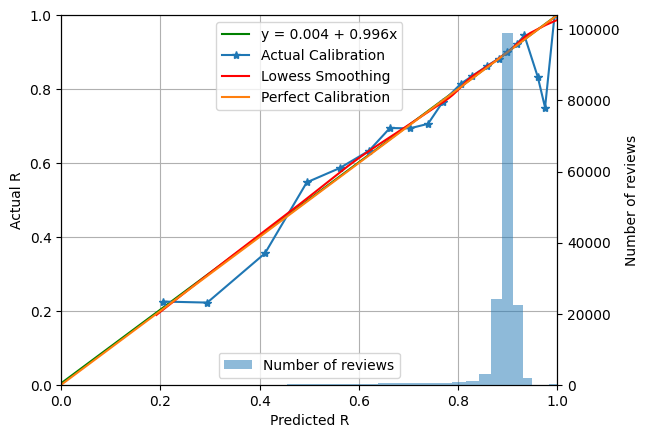

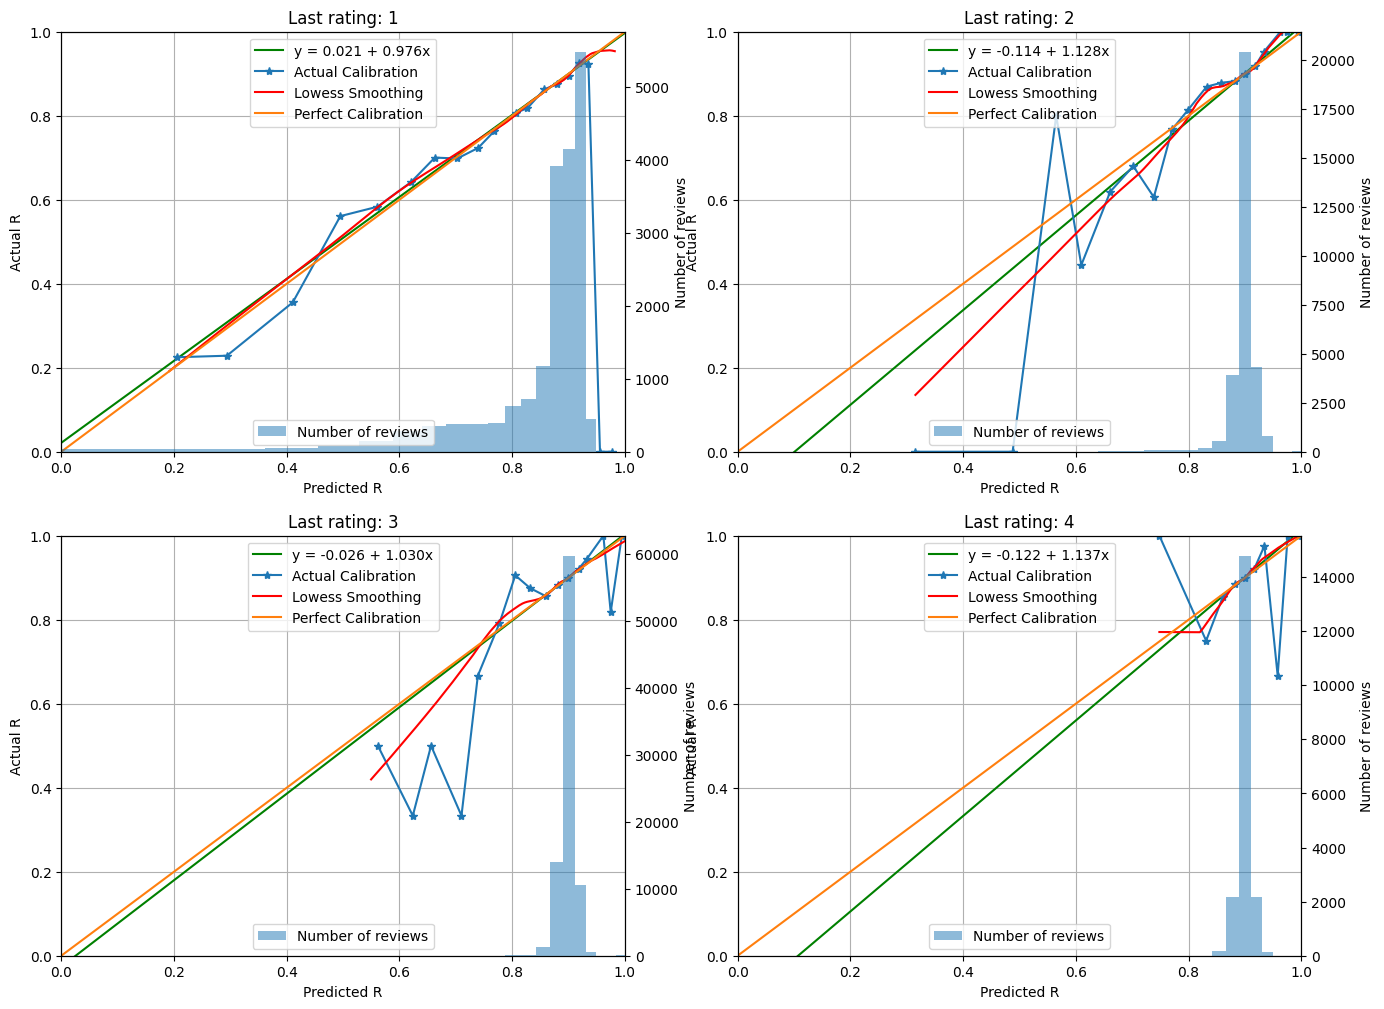

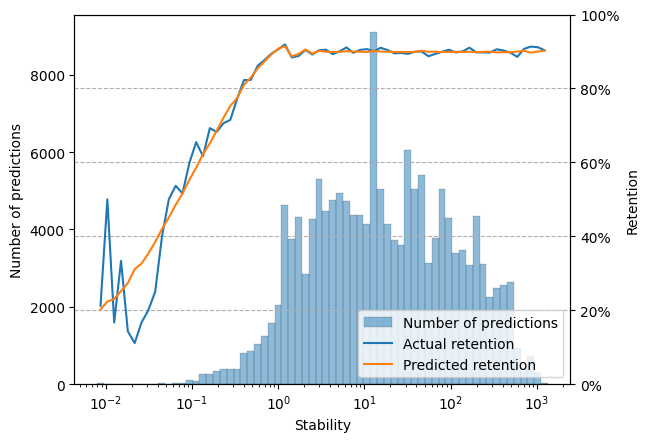

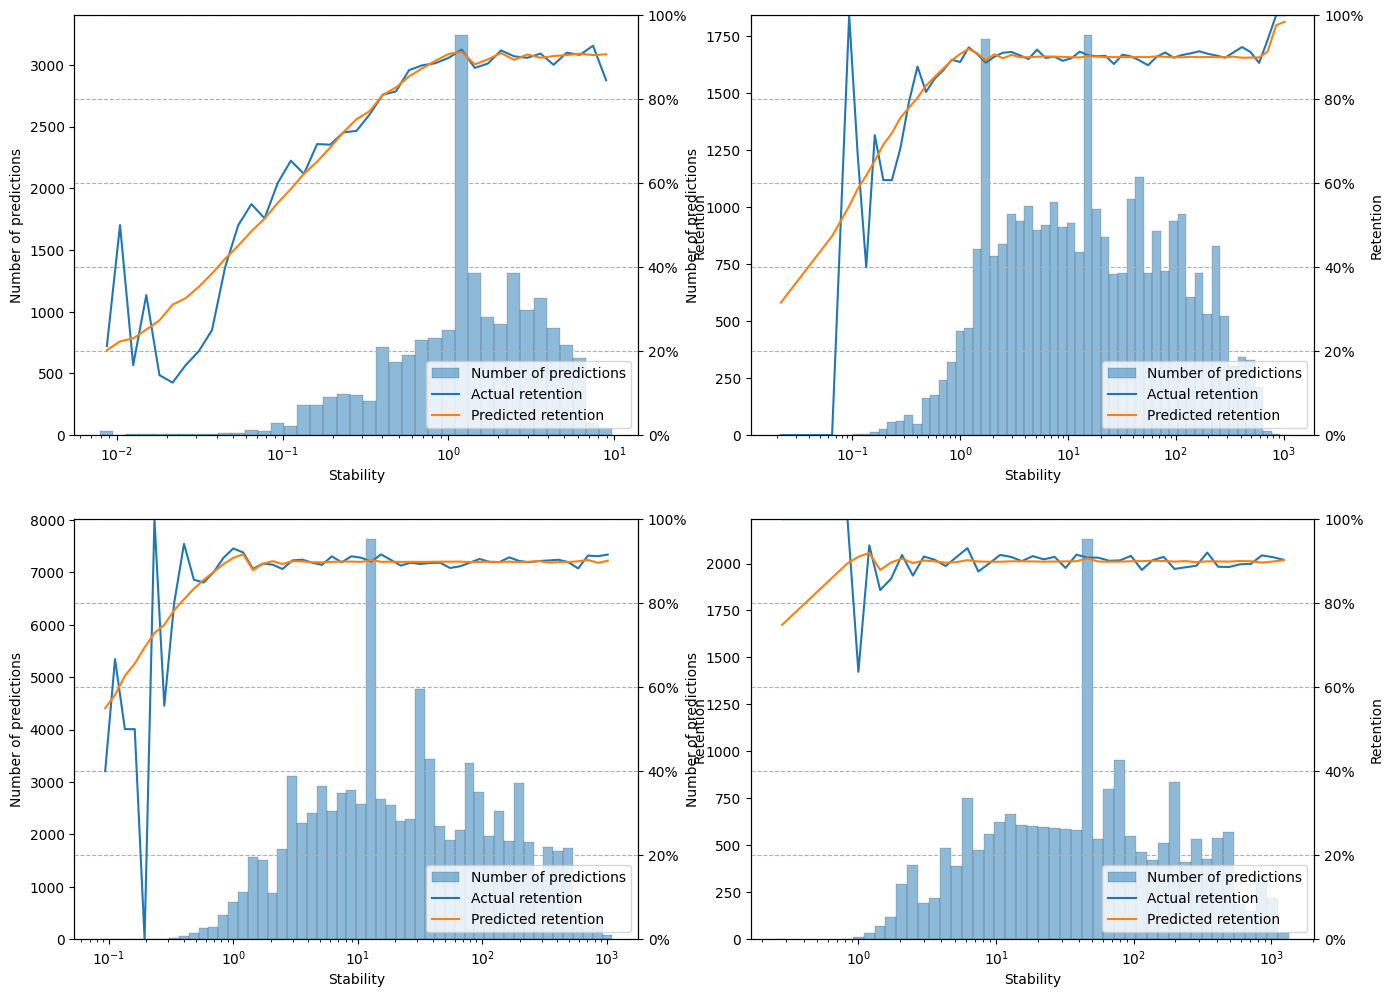

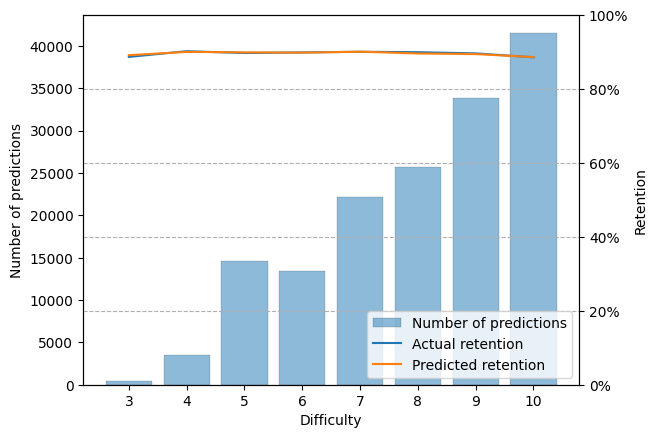

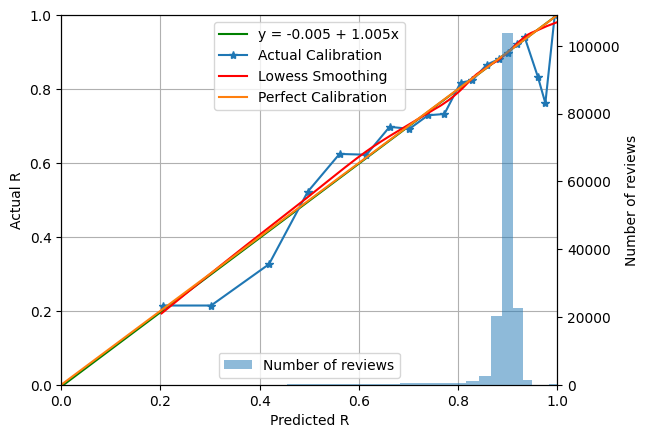

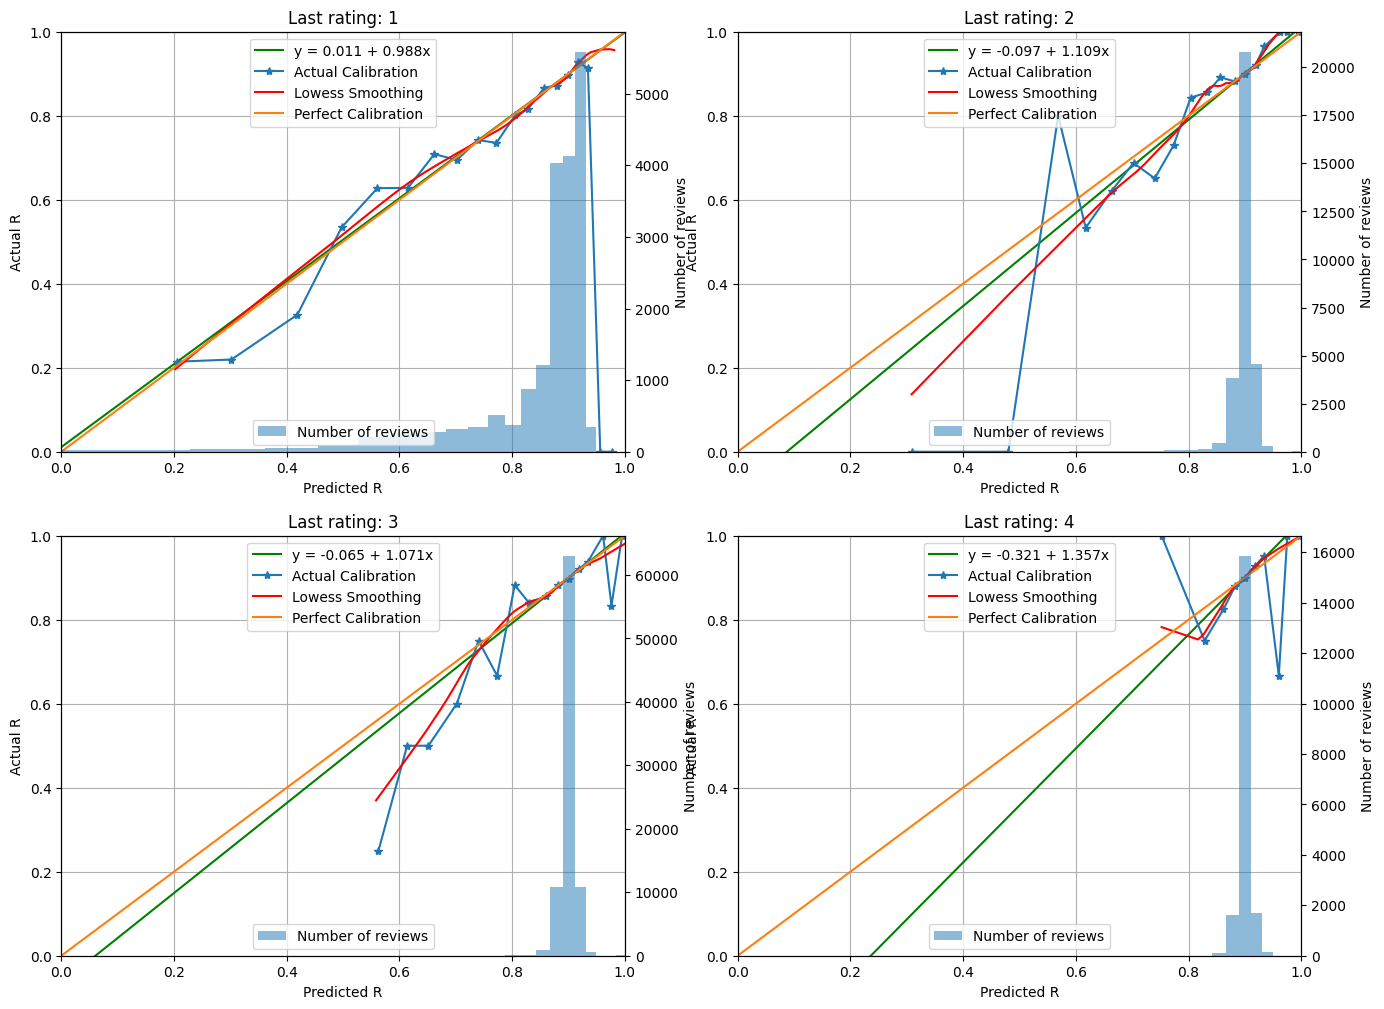

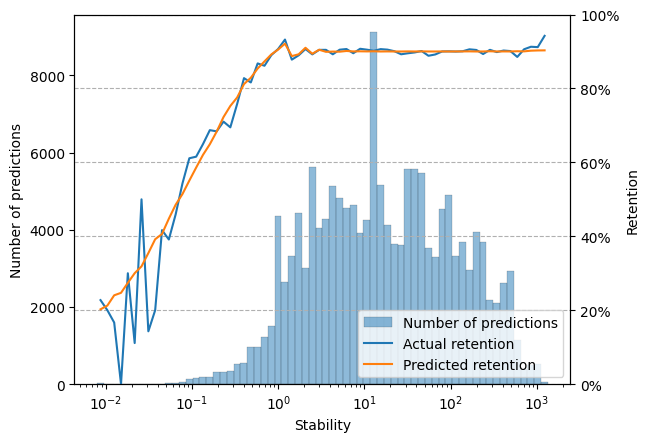

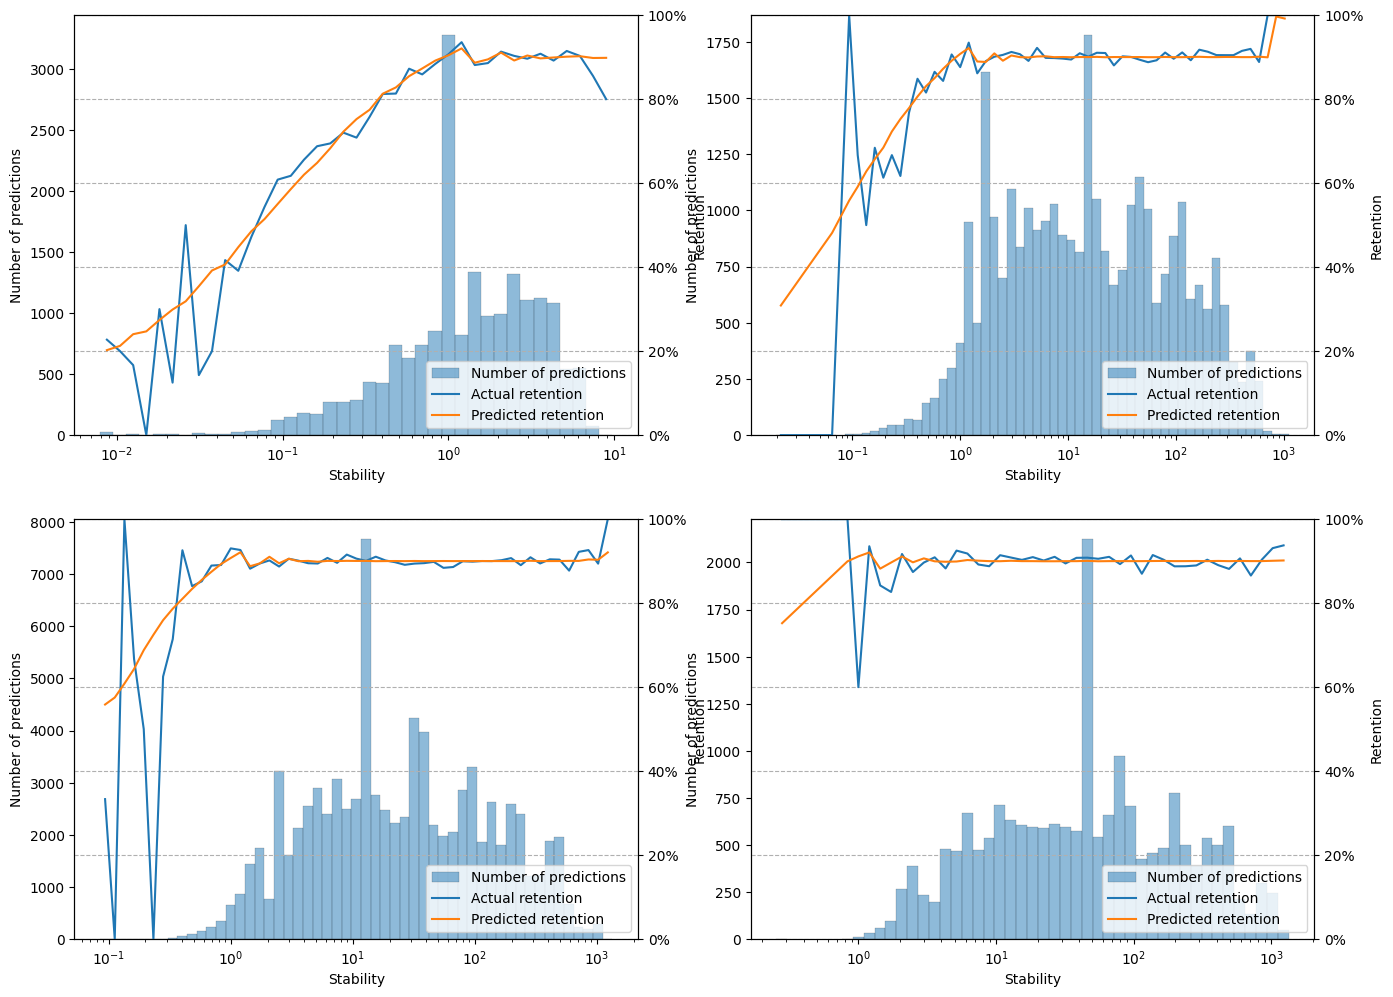

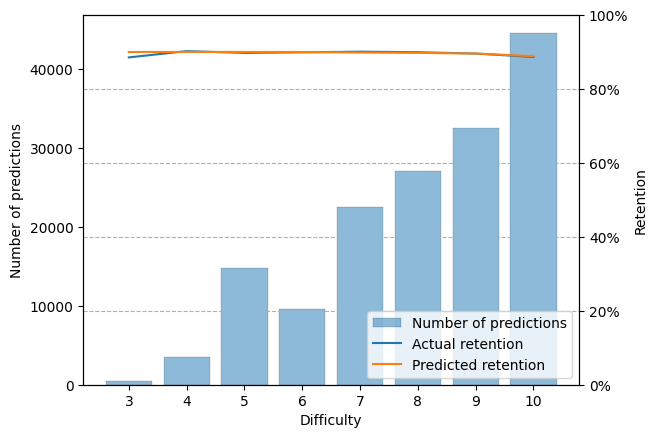

In [4]:
learn_span_list = [7, 15, 30, 60, 120, 240, 480, 960, 1920]
sample_size_list = []
logloss_list = []
rmse_list = []
auc_list = []
avg_smape_list = []
ideal_logloss_list = []
ideal_rmse_list = []
ideal_auc_list = []

for learn_span in learn_span_list:
    print(f"learn_span: {learn_span}")
    revlogs = generate_revlog_from_simulation(initial_parameters, learn_span=learn_span)
    df = preprocess_revlog(revlogs)
    sample_size, logloss, rmse, auc, avg_smape, dataset = train_and_evaluate(df)
    sample_size_list.append(sample_size)
    logloss_list.append(logloss)
    rmse_list.append(rmse)
    auc_list.append(auc)
    avg_smape_list.append(avg_smape)

    ideal_logloss, ideal_rmse, ideal_auc = evaluate_initial_parameters(dataset)
    ideal_logloss_list.append(ideal_logloss)
    ideal_rmse_list.append(ideal_rmse)
    ideal_auc_list.append(ideal_auc)

    print("--------------------------------")

In [5]:
np.set_printoptions(precision=6, suppress=True)
print(f"logloss (trained - ideal): {np.array(logloss_list) - np.array(ideal_logloss_list)}")
print(f"RMSE(bins) (trained - ideal): {np.array(rmse_list) - np.array(ideal_rmse_list)}")
print(f"AUC (trained - ideal): {np.array(auc_list) - np.array(ideal_auc_list)}")

logloss (trained - ideal): [-0.011903 -0.001666 -0.001926 -0.001259 -0.000077 -0.000233 -0.000116
 -0.000017 -0.000013]
RMSE(bins) (trained - ideal): [-0.010198 -0.001355 -0.002612 -0.002188 -0.00009  -0.001017 -0.000718
 -0.000089  0.000066]
AUC (trained - ideal): [ 0.059524  0.019003  0.023629  0.021643 -0.00022   0.002385  0.000864
 -0.000141 -0.000921]


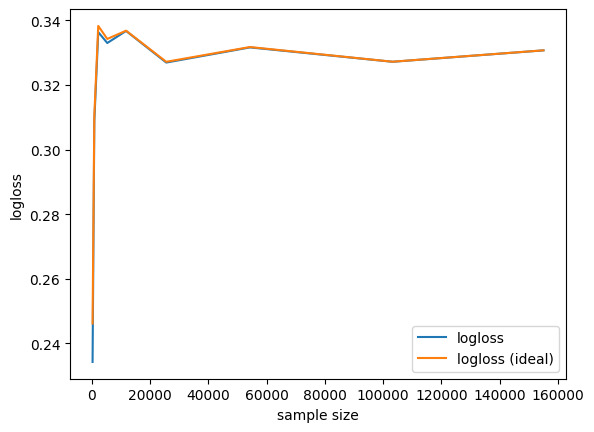

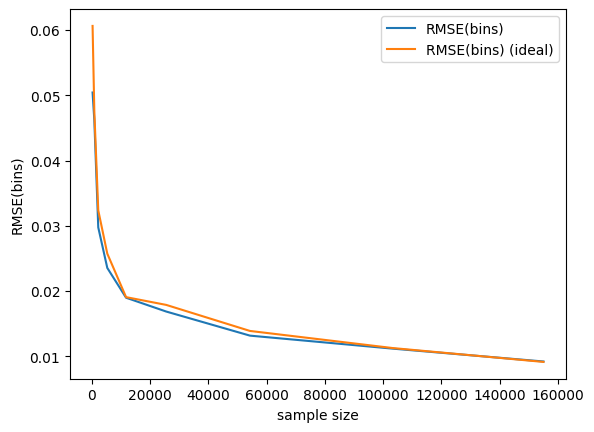

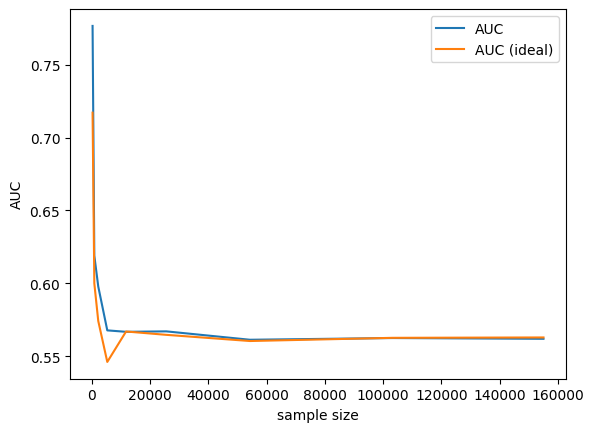

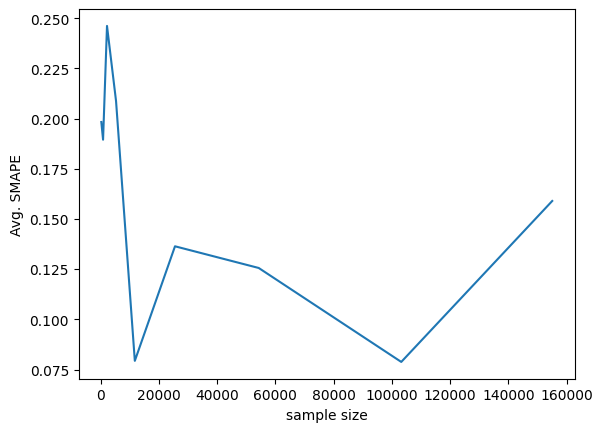

In [6]:
plt.plot(sample_size_list, logloss_list, label="logloss")
plt.plot(sample_size_list, ideal_logloss_list, label="logloss (ideal)")
plt.ylabel("logloss")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, rmse_list, label="RMSE(bins)")
plt.plot(sample_size_list, ideal_rmse_list, label="RMSE(bins) (ideal)")
plt.ylabel("RMSE(bins)")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, auc_list, label="AUC")
plt.plot(sample_size_list, ideal_auc_list, label="AUC (ideal)")
plt.ylabel("AUC")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, avg_smape_list)
plt.ylabel("Avg. SMAPE")
plt.xlabel("sample size")
plt.show()
